In [1]:
%config Completer.use_jedi = False

In [2]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/naekid/opt/anaconda3/envs/personal/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
df = sm.datasets.co2.load_pandas().data

df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [51]:
monthly = df.resample('m').mean()

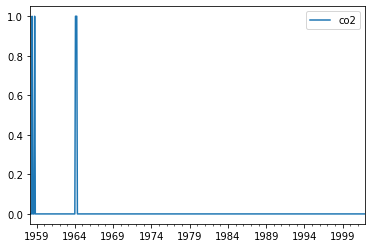

In [6]:
monthly.isna().astype(int).plot()

In [60]:
# monthly = monthly.fillna(method='pad')
monthly = monthly.interpolate(method='linear')

In [61]:
monthly.isna().sum()

co2    0
dtype: int64

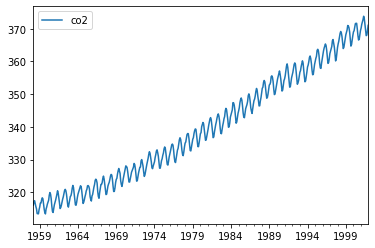

In [62]:
monthly.plot()

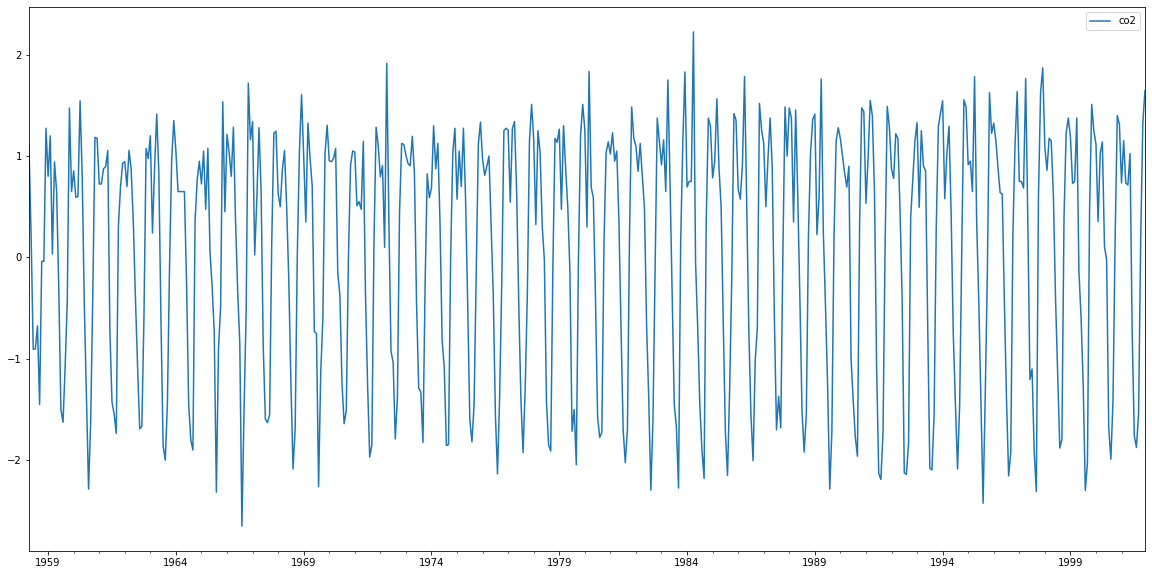

In [63]:
fig, ax = plt.subplots(figsize=(20,10))
monthly.diff().dropna().plot(ax=ax)

Augmented Dickey-Fuller Test Result: (-8.39802647385306, 2.2709847931479795e-13)


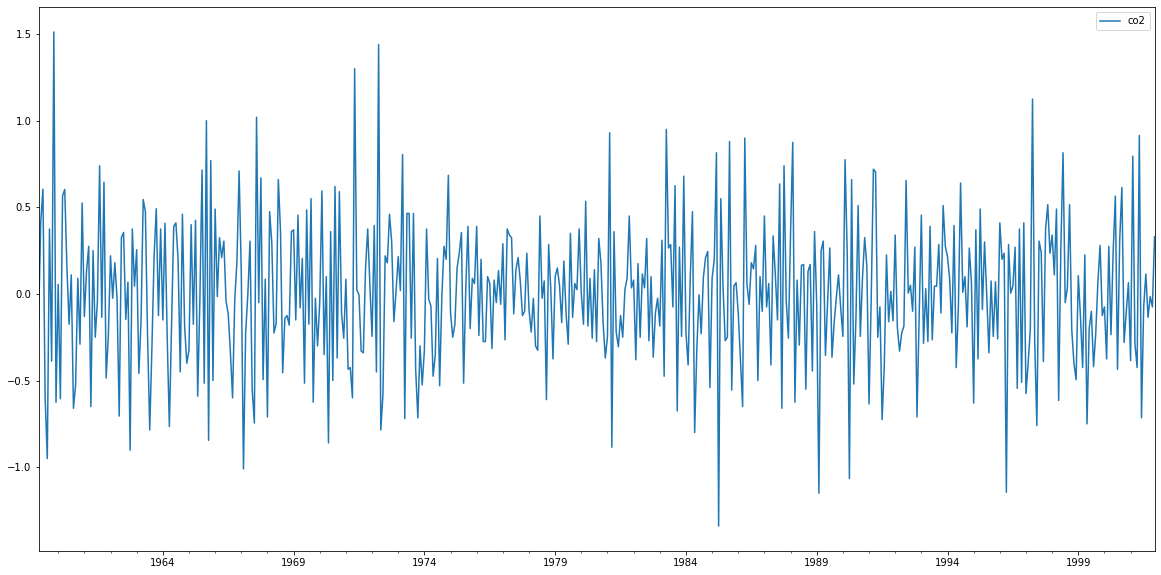

In [64]:
from statsmodels.tsa.stattools import adfuller
fig, ax = plt.subplots(figsize=(20,10))
differenced = monthly.diff().diff(12).dropna()
differenced.plot(ax=ax)
print('Augmented Dickey-Fuller Test Result:', adfuller(differenced)[:2])

In [65]:
# parameters
d = 1
D = 1
m = 12

In [ ]:
import pmdarima as pm

In [28]:
results = pm.auto_arima( 
    monthly,             # data
    d=d,          # non-seasonal arguments
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    seasonal=True,  # is the time series seasonal
    m=m,
    D=D,
    start_P=1,
    start_Q=1,
    max_P=2,
    max_Q=2,
)

In [ ]:
# results.summary()

In [72]:
# results.plot_diagnostics(figsize=(20,15))
# plt.tight_layout()

In [78]:
predictions = results.predict_in_sample()

In [89]:
# forecasts, conf_int = model.predict(n_periods=48, return_conf_int=True)
# plt.plot(forecasts)

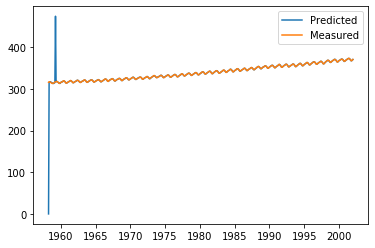

In [76]:
plt.plot(monthly.index, predictions, label='Predicted')
plt.plot(monthly['co2'], label='Measured')
plt.legend()

# Use statsmodels SARIMAX

In [134]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [135]:
# Create model object
model = SARIMAX(monthly, 
                order=(1,1,1), 
                seasonal_order=(0,1,1,12), 
                trend='c')

In [136]:
results = model.fit()

In [137]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -123.697
Date:                            Thu, 30 Jun 2022   AIC                            257.394
Time:                                    23:34:02   BIC                            278.595
Sample:                                03-31-1958   HQIC                           265.704
                                     - 12-31-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.001      1.548      0.122      -0.000       0.003
ar.L1          0.2915      0.106      2.746      0.006       0.083       0.500
ma.L1         -0.6180      0.091     -6.791      0.000      -0.796      -0.440
ma.S.L12      -0.8655      0.026    -33.290      0.000      -0.916      -0.815
sigma2         0.0918      0.006     16.203      0.000       0.081       0.103
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.85   Prob(JB):                         0.91
Heteroskedasticity (H):               0.80   Skew:                            -0.01
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

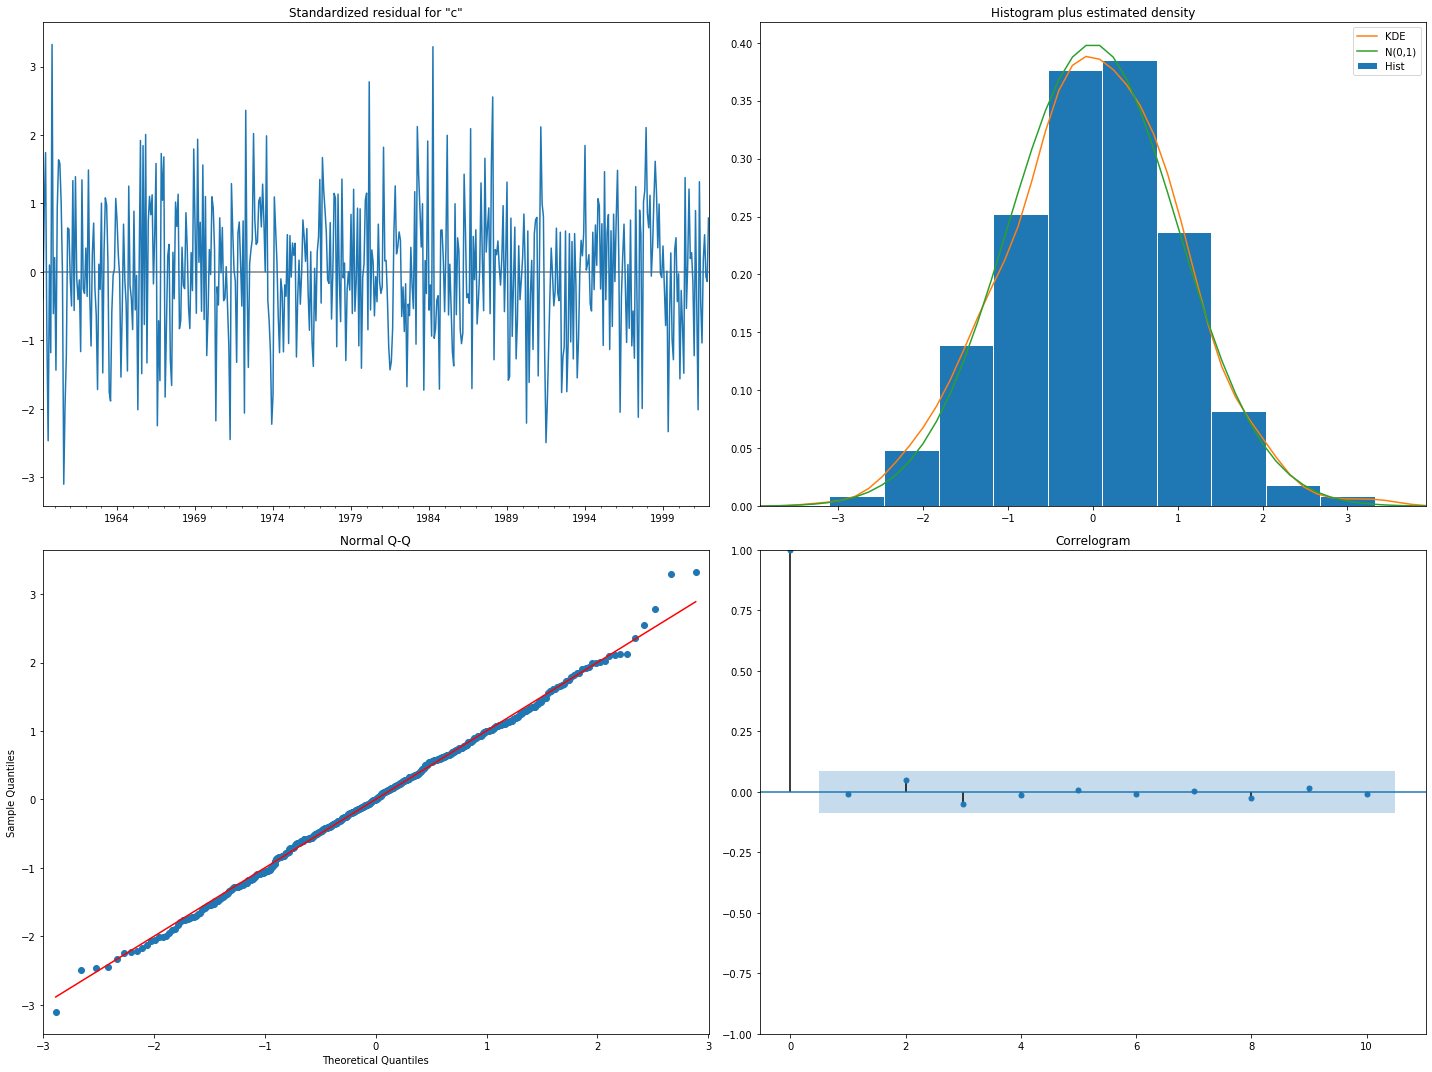

In [138]:
results.plot_diagnostics(figsize=(20,15))
plt.tight_layout()

# Predict - in-sample

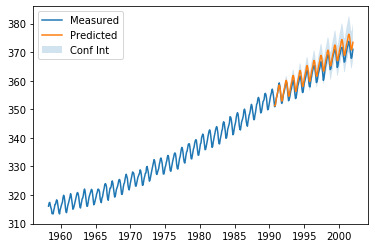

In [139]:
# make dynamice predictions with confidence interval
predictions = results.get_prediction(start=-136, dynamic=True)

mean = predictions.predicted_mean

conf_int = predictions.conf_int()

dates = mean.index

plt.figure()

# Plot past CO2 levels
plt.plot(monthly.index, monthly, label='Measured')

# Plot the prediction means as line
plt.plot(dates, mean, label='Predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int['lower co2'], conf_int['upper co2'], alpha=0.2, label='Conf Int')

# Plot legend and show figure
plt.legend()
plt.show()

# Forecast

Index(['lower co2', 'upper co2'], dtype='object')


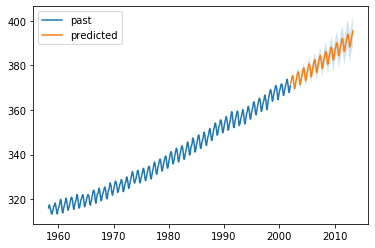

In [140]:
# Create forecast object
forecast_object = results.get_forecast(136)

# Extract predicted mean attribute
mean = forecast_object.predicted_mean

# Calculate the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

print(conf_int.columns)
plt.figure()

# Plot past CO2 levels
plt.plot(monthly.index, monthly, label='past')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int['lower co2'], conf_int['upper co2'], alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.show()